In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np
from scipy import ndimage as ndi
#from skimage.segmentation import watershed
#from skimage.feature import peak_local_max
#from scipy import ndimage as ndi
import napari
import tifffile
import matplotlib.pyplot as plt
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)


In [2]:
Ano1 = tifffile.imread('/Users/ngrainger/Documents/napari/test/RP-Prox-Ano1-Contrast.tif')
DAPI = tifffile.imread('/Users/ngrainger/Documents/napari/test/RP-Prox-DAPI.tif')


In [3]:
spacing = np.array([0.25,0.31, 0.31])

In [4]:
viewer = napari.view_image(
    Ano1,
    contrast_limits=[0,4095],
    scale=spacing,
    ndisplay = 3,
    colormap = 'green'
)

/opt/anaconda3/lib/python3.9/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [5]:
viewer.add_image(
    DAPI,
    contrast_limits=[0,4095],
    scale=spacing,
    blending = 'additive',
    colormap = 'magenta'
)

<Image layer 'DAPI' at 0x7fe0d8334490>

In [6]:
edges = filters.sobel(Ano1)

In [7]:
viewer.add_image(
    edges,
    scale=spacing,
    blending='additive', 
    colormap='blue', 
    name='edges'
)

<Image layer 'edges' at 0x7fe0fd49b700>

In [11]:
denoised = ndi.median_filter(Ano1, size=2)

In [12]:
li_thresholded = denoised > filters.threshold_li(denoised)

/opt/anaconda3/lib/python3.9/site-packages/skimage/filters/thresholding.py:701: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


In [13]:
viewer.add_image(li_thresholded, scale=spacing, name='thresholded', opacity=0.3)

<Image layer 'thresholded [1]' at 0x7fdfb8090ee0>

In [14]:
filled = ndi.binary_fill_holes(li_thresholded)

viewer.add_image(filled,scale=spacing, name='filled', opacity=0.3)

<Image layer 'filled' at 0x7fdfb80a28e0>

In [15]:
width = 20

remove_holes = morphology.remove_small_holes(
    filled, 
    area_threshold=width ** 3
)

In [19]:
width = 3

remove_objects = morphology.remove_small_objects(
    filled, 
    min_size=width ** 2
)

viewer.add_image(remove_objects, scale=spacing, name='cleaned', opacity=0.3);

In [20]:
labels = measure.label(remove_objects)

viewer.add_labels(labels,scale=spacing, name='thresh labels')

<Labels layer 'thresh labels' at 0x7fdf98085bb0>

In [21]:
transformed = ndi.distance_transform_edt(remove_objects, sampling=spacing)

maxima = morphology.local_maxima(transformed)
viewer.add_points(np.transpose(np.nonzero(maxima)), scale=spacing, name='bad points')

<Points layer 'bad points' at 0x7fe0bb976d30>

In [19]:
viewer.layers['bad points'].visible = False
points = viewer.add_points(name='interactive points', scale=spacing, ndim=3)
points.mode = 'add'

# now, annotate the centers of the nuclei in your image

In [22]:
#marker_locations = points.data
#
#markers = np.zeros(Ano1.shape, dtype=np.uint32)
#marker_indices = tuple(np.round(marker_locations).astype(int).T)
#markers[marker_indices] = np.arange(len(marker_locations)) + 1
#markers_big = morphology.dilation(markers, morphology.ball(5))

#segmented = segmentation.watershed(
#    edges,
#   markers_big, 
#    mask=remove_objects
#)

#viewer.add_labels(segmented, scale=spacing, name='segmented')

NameError: name 'points' is not defined

In [21]:
#segmented_padded = np.pad(
#    segmented,
#    ((1, 1), (0, 0), (0, 0)),
#    mode='constant',
#    constant_values=0,
#)

NameError: name 'segmented' is not defined

In [ ]:
#interior_labels = segmentation.clear_border(segmented_padded)[1:-1]

In [23]:
relabeled, fw_map, inv_map = segmentation.relabel_sequential(labels)

print("relabeled labels: {}".format(np.unique(relabeled)))

relabeled labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 

In [25]:
regionprops = measure.regionprops(labels, intensity_image=Ano1)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

Supported properties:
  area
  bbox
  bbox_area
  centroid
  convex_area
  convex_image
  coords
  equivalent_diameter
  euler_number
  extent
  feret_diameter_max
  filled_area
  filled_image
  image
  inertia_tensor
  inertia_tensor_eigvals
  intensity_image
  label
  local_centroid
  major_axis_length
  max_intensity
  mean_intensity
  min_intensity
  minor_axis_length
  moments
  moments_central
  moments_normalized
  slice
  solidity
  weighted_centroid
  weighted_local_centroid
  weighted_moments
  weighted_moments_central
  weighted_moments_normalized

Unsupported properties:
  eccentricity
  moments_hu
  orientation
  perimeter
  perimeter_crofton
  weighted_moments_hu


In [26]:
print(f'measured regions: {[regionprop.label for regionprop in regionprops]}')

measured regions: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

In [27]:
vmin, vmax = np.quantile(Ano1, q=(0.005, 0.995))

stretched = exposure.rescale_intensity(
    Ano1, 
    in_range=(vmin, vmax), 
    out_range=np.float32
)

viewer.add_image(stretched, scale=spacing, contrast_limits=[0, 1], name='stretched')

<Image layer 'stretched' at 0x7fe0a86022e0>

In [58]:
#from skimage.filters import threshold_otsu

In [62]:
#edges_thresh = threshold_otsu(edges)

In [63]:
#binary2 = edges > edges_thresh

In [64]:
#viewer.add_image(
#    binary2,
#    scale=spacing,
#    blending = 'additive',
#    colormap = 'blue'
#)

<Image layer 'binary2' at 0x7fec3931f460>

In [29]:
import pandas as pd


info_table = pd.DataFrame(
    measure.regionprops_table(
        labels, Ano1,
        properties=['label', 'slice', 'area', 'mean_intensity', 'coords'],
    )
).set_index('label')

In [30]:
info_table

,slice,area,mean_intensity,coords
label,,,,
1,"(slice(6, 20, None), slice(531, 539, None), sl...",185,46405.864865,"[[6, 533, 255], [6, 533, 256], [6, 533, 257], ..."
2,"(slice(6, 14, None), slice(637, 641, None), sl...",25,39321.000000,"[[6, 639, 197], [7, 639, 197], [7, 640, 197], ..."
3,"(slice(6, 16, None), slice(674, 677, None), sl...",25,41942.400000,"[[6, 675, 186], [7, 674, 186], [7, 675, 185], ..."
4,"(slice(7, 24, None), slice(648, 653, None), sl...",129,45722.093023,"[[7, 648, 195], [7, 649, 195], [7, 649, 196], ..."
5,"(slice(8, 17, None), slice(487, 492, None), sl...",64,39935.390625,"[[8, 488, 306], [8, 488, 307], [8, 489, 306], ..."
...,...,...,...,...
529,"(slice(48, 53, None), slice(505, 507, None), s...",13,35288.076923,"[[48, 505, 627], [49, 505, 627], [49, 505, 628..."
530,"(slice(48, 53, None), slice(568, 570, None), s...",17,34695.000000,"[[48, 568, 275], [48, 568, 276], [48, 569, 275..."
531,"(slice(49, 53, None), slice(248, 251, None), s...",11,29788.636364,"[[49, 249, 641], [50, 249, 640], [50, 249, 641..."


<AxesSubplot:xlabel='area', ylabel='label'>

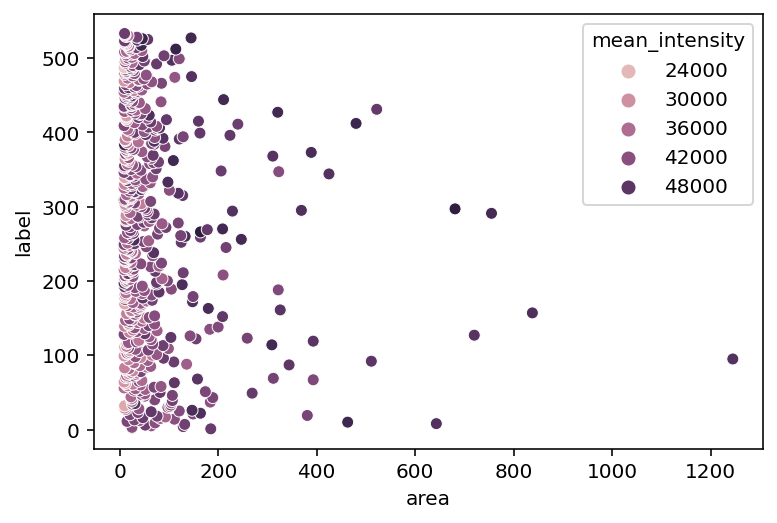

In [33]:
import seaborn as sns

sns.scatterplot(x='area', y='label', data=info_table, hue='mean_intensity')

<AxesSubplot:xlabel='area', ylabel='Count'>

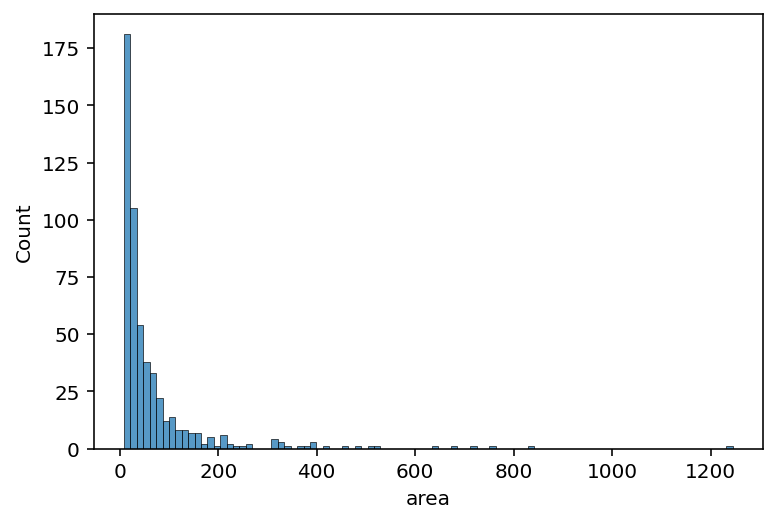

In [32]:
import seaborn as sns

sns.histplot(data=info_table, x='area')

In [ ]:
from skimage.filters import threshold_otsu

In [18]:
thresh = threshold_otsu(Ano1)

In [19]:
binary = Ano1 > thresh

In [20]:
viewer.add_image(
    binary,
    scale=spacing,
    blending = 'additive',
    colormap = 'blue'
)

<Image layer 'binary' at 0x7fa84059fa60>

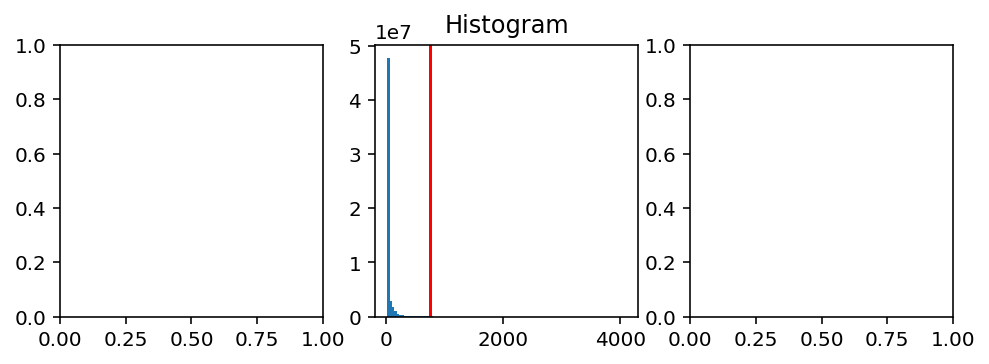

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[1] = plt.subplot(1, 3, 2)

ax[1].hist(Ano1.ravel(), bins=100)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')


plt.show()

In [6]:
denoised = ndi.median_filter(pdgfra, size=3)

In [7]:
li_thresholded = denoised > filters.threshold_li(denoised)

In [10]:
viewer.add_image(
    li_thresholded,
    scale=spacing,
    opacity=0.3)

<Image layer 'li_thresholded' at 0x7fed5050ab20>

In [11]:
import matplotlib.pyplot as plt

from matplotlib.backends.backend_qt5agg import FigureCanvas

ValueError: too many values to unpack (expected 1)

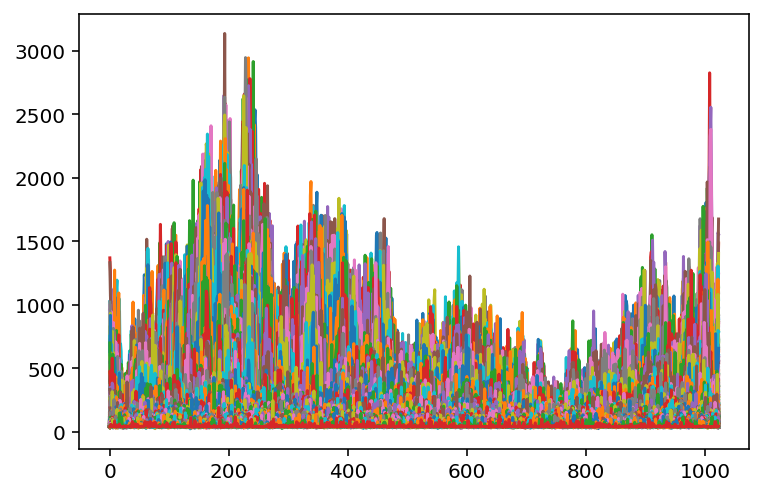

In [15]:
# create mpl figure with subplots
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
(line,) = ax.plot(pdgfra_layer.data[1])  # linescan through the middle of the image



In [ ]:
from skimage import filters

edges = filters.scharr(pdgfra)

pdgfra_layer = viewer.layers['pdgfra']
pdgfra_layer.blending = 'additive'
pdgfra_layer.colormap = 'green'

viewer.add_image(
    edges,
    scale=spacing,
    blending = 'additive',
    colormap = 'magenta'
)